In [1]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/logistics_dataset.csv")
df.shape,df.dtypes,df.head(),df.info(), df.describe()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11745040 entries, 0 to 11745039
Data columns (total 18 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   origin                       object 
 1   destination                  object 
 2   distance_km                  float64
 3   transport_type               object 
 4   transport_type_code          int64  
 5   cargo_weight_tons            float64
 6   commodity                    object 
 7   commodity_code               int64  
 8   year                         int64  
 9   ton_km                       float64
 10  emission_factor_g_tkm        int64  
 11  co2_emissions_kg             float64
 12  co2_per_liter                float64
 13  fuel_consumption_liters      float64
 14  co2_per_km                   float64
 15  co2_per_ton_km               float64


((11745040, 18),
 origin                          object
 destination                     object
 distance_km                    float64
 transport_type                  object
 transport_type_code              int64
 cargo_weight_tons              float64
 commodity                       object
 commodity_code                   int64
 year                             int64
 ton_km                         float64
 emission_factor_g_tkm            int64
 co2_emissions_kg               float64
 co2_per_liter                  float64
 fuel_consumption_liters        float64
 co2_per_km                     float64
 co2_per_ton_km                 float64
 fuel_efficiency_l_per_100km    float64
 environmental_class             object
 dtype: object,
           origin    destination  distance_km transport_type  \
 0  Birmingham AL  Birmingham AL     0.099847          Truck   
 1  Birmingham AL     Rest of AL     0.199574          Truck   
 2  Birmingham AL     Rest of FL     0.523536          

In [2]:
df = df.dropna(subset=["origin", "destination", "distance_km", "co2_emissions_kg"])
df = df[df["co2_emissions_kg"] >= 0]
df["transport_type"] = df["transport_type"].str.lower().str.strip()
df["environmental_class"] = df["environmental_class"].str.lower().str.strip()

## Общая статистика выбросов CO₂

В этом разделе рассчитываются базовые показатели по всей логистической сети:

- **Общие выбросы CO₂** — суммарный вклад всех маршрутов.
- **Средняя интенсивность выбросов на тонно-километр** — характеризует экологическую эффективность перевозок.
- **Медианная интенсивность** — даёт представление о типичном уровне выбросов без влияния выбросов
.

In [3]:
#Общий углеродный след
total_co2_kg = df["co2_emissions_kg"].sum()

#Средняя интенсивность выбросов на тонно-км
avg_co2_per_tkm = df["co2_per_ton_km"].mean()

#Выбросы по типу транспорта
co2_by_transport = df.groupby("transport_type")["co2_emissions_kg"].sum().sort_values(ascending=False)

#Доля классов экологичности
env_class_share = df["environmental_class"].value_counts(normalize=True) * 100

#Топ-10 "грязных" маршрутов
top10_polluting = df.sort_values("co2_per_ton_km", ascending=False).head(10)[[
    "origin", "destination", "transport_type", "commodity","co2_emissions_kg", "co2_per_ton_km","ton_km"
]]
print(f"Общие выбросы CO₂: {total_co2_kg:,.0f} кг")
print(f"Средняя интенсивность выбросов CO₂ на т·км: {avg_co2_per_tkm:.3f} кг/т·км")
print("Распределение по классам экологичности:\n", env_class_share)


Общие выбросы CO₂: 2,419,886 кг
Средняя интенсивность выбросов CO₂ на т·км: 0.169 кг/т·км
Распределение по классам экологичности:
 environmental_class
medium    42.010636
low       34.278785
high      23.710579
Name: proportion, dtype: float64


In [14]:
summary_stats = df.groupby(["transport_type","environmental_class"])["co2_per_ton_km"].agg(["median", "mean", "std", "count","sum"]).sort_values(by="median", ascending=False)
summary_stats

,,median,mean,std,count,sum
transport_type,environmental_class,,,,,
air (include truck-air),high,0.570,0.570,0.0,2784817,1587345.690
other and unknown,medium,0.080,0.080,0.0,42132,3370.560
truck,medium,0.071,0.071,0.0,4689676,332966.996
water,medium,0.035,0.035,0.0,202358,7082.530
rail,low,0.016,0.016,0.0,1375892,22014.272
multiple modes & mail,low,0.012,0.012,0.0,2625327,31503.924
pipeline,low,0.004,0.004,0.0,24838,99.352


<Axes: title={'center': 'Средняя интенсивность выбросов CO₂ (кг/т·км)'}, xlabel='Transport Type', ylabel='kg / ton·km'>

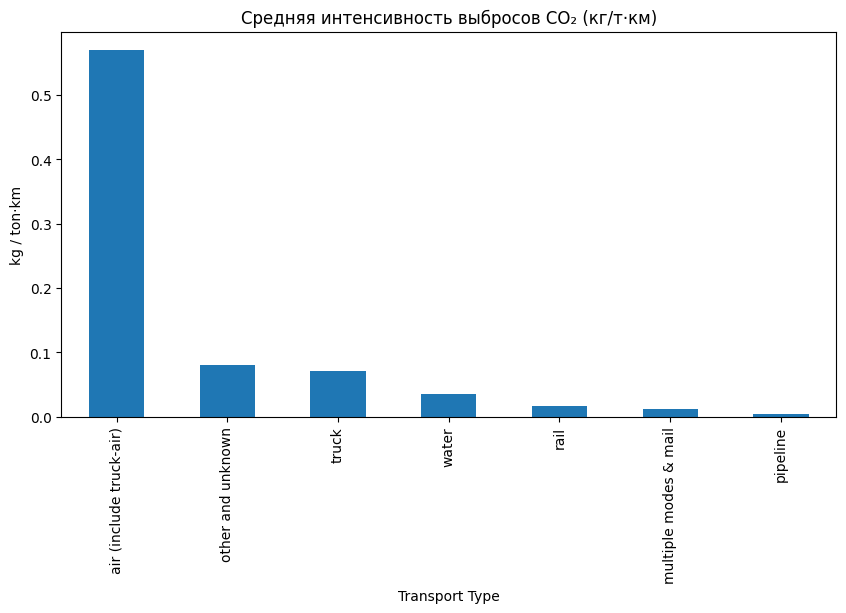

In [7]:
# Средняя интенсивность по транспортам

co2_intensity_mean = df.groupby("transport_type")["co2_per_ton_km"].mean().sort_values(ascending=False)
co2_intensity_mean.plot(kind="bar", title="Средняя интенсивность выбросов CO₂ (кг/т·км)", ylabel="kg / ton·km", xlabel="Transport Type", figsize=(10, 5))


Видим, что высокая интенсивность выбросов происходит на Воздух, включая грузовики, это самый высокий показатель по загрязнения. Можем заметить, что в группе среднего загрязнения находится "другие" маршруты, грузовики и водный транспорт, но, в отличие от последнего, первые два близко расположены к уровню загрязнения (0.08 и 0.071 соответсвенно), при этом грузовики являются самым используемым маршрутом. Самые экологичные это поезда, мультимодальные и трубы.

In [4]:
df.groupby([
    "origin", "destination", "transport_type", "commodity"])["co2_emissions_kg"].sum().sort_values(ascending=False)

origin                destination                       transport_type         commodity          
Iowa                  Iowa                              truck                  Cereal grains          1.649626e+04
Alaska                Los Angeles CA                    water                  Crude petroleum        1.426174e+04
Rest of NE            Rest of NE                        truck                  Cereal grains          1.231729e+04
Rest of TX            Rest of TX                        truck                  Fuel oils              1.051143e+04
                                                                               Gasoline               9.170127e+03
                                                                                                          ...     
Buffalo NY  CFS Area  Washington DC-VA-MD-WV (DC Part)  multiple modes & mail  Basic chemicals        1.930800e-08
Rest of NY            Rest of MD                        multiple modes & mail  Pharmaceuticals        1.930800e-08
Rest of CA            Rest of AZ                        multiple modes & mail  Articles-base metal    1.930800e-08
                      Tucson AZ                         multiple modes & mail  Articles-base metal    1.930800e-08
Maine                 Chicago IL-IN-WI (IL Part)        multiple modes & mail  Other ag prods.        1.930800e-08
Name: co2_emissions_kg, Length: 992767, dtype: float64

Здесь представлена таблица по всем маршрутам, отсортированные по большому количеству выбросов.

In [5]:
top10_polluting

,origin,destination,transport_type,commodity,co2_emissions_kg,co2_per_ton_km,ton_km
11745028,Seattle WA,Los Angeles CA,air (include truck-air),Mixed freight,0.195577,0.57,0.343118
11745031,Portland OR-WA (WA Part),Los Angeles CA,air (include truck-air),Mixed freight,0.015624,0.57,0.027411
11745033,Rest of WA,Los Angeles CA,air (include truck-air),Mixed freight,0.053631,0.57,0.094089
11745034,West Virginia,New York NY-NJ-CT-PA (NY Part),air (include truck-air),Mixed freight,0.000168,0.57,0.000294
7516610,Chicago IL-IN-WI (IL Part),Portland OR-WA (OR Part),air (include truck-air),Textiles/leather,0.008113,0.57,0.014233
7516613,Chicago IL-IN-WI (IL Part),Rest of OR,air (include truck-air),Textiles/leather,0.004689,0.57,0.008227
7516615,Chicago IL-IN-WI (IL Part),Philadelphia PA-NJ-DE-MD (PA Part),air (include truck-air),Textiles/leather,0.094963,0.57,0.166602
7516617,Chicago IL-IN-WI (IL Part),Pittsburgh PA-OH-WV (PA Part),air (include truck-air),Textiles/leather,0.034823,0.57,0.061094
35,Alaska,Alaska,air (include truck-air),Live animals/fish,0.004781,0.57,0.008388
7516620,Chicago IL-IN-WI (IL Part),New York NY-NJ-CT-PA (PA Part),air (include truck-air),Textiles/leather,0.019494,0.57,0.034199


Здесь 10 самых загрязняющих маршрутов по тонн-км.

## Распределения

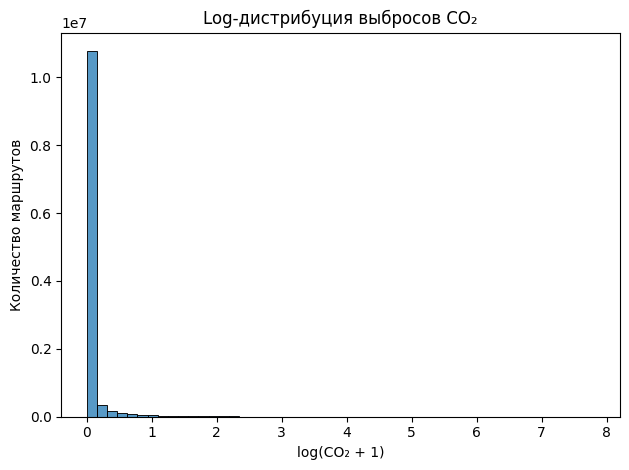

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Гистограмма выбросов CO₂ по маршрутам
plt.figure()
sns.histplot(np.log1p(df["co2_emissions_kg"]), bins=50)
plt.title("Log-дистрибуция выбросов CO₂")
plt.xlabel("log(CO₂ + 1)")
plt.ylabel("Количество маршрутов")
plt.tight_layout()
plt.show()

В целях удобного просмотра графика, он был приведён в лог-масштаб, главная суть состоит в том, что у нас довольно малое количество маршрутов, которые вносят огромный вклад в загрязние, можно обратить внимание на них в процессе оптимизации.

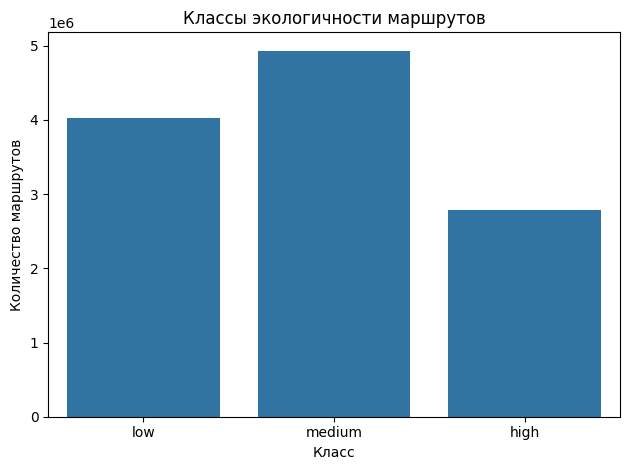

In [8]:
# Распределение классов экологичности
plt.figure()
sns.countplot(x="environmental_class", data=df,
              order=["low", "medium", "high"])
plt.title("Классы экологичности маршрутов")
plt.xlabel("Класс")
plt.ylabel("Количество маршрутов")
plt.tight_layout()
plt.show()

На графике показано, какая доля маршрутов попадает в экологические классы:

- `low` — наименее углеродоёмкие маршруты
- `medium` — маршруты со средним уровнем выбросов
- `high` — маршруты с высоким уровнем выбросов

Анализ этого распределения позволяет оценить, сколько маршрутов нуждаются в приоритетной декарбонизации.

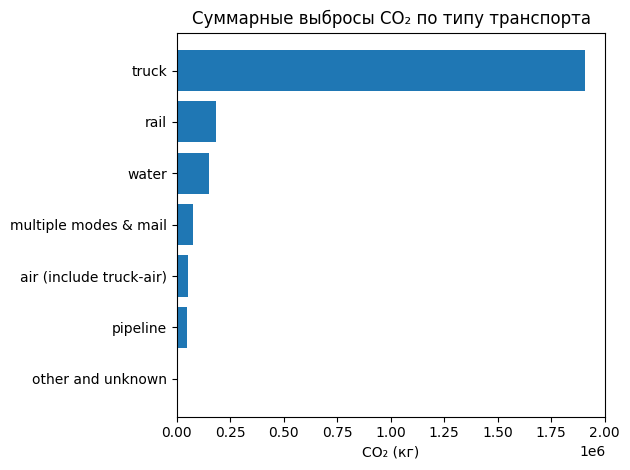

In [17]:
# График выбросов по типу транспорта
plt.figure()
co2_by_type = df.groupby("transport_type")["co2_emissions_kg"].sum().sort_values().reset_index()
plt.barh(y=co2_by_type['transport_type'],width=co2_by_type['co2_emissions_kg'])
plt.title("Суммарные выбросы CO₂ по типу транспорта")
plt.xlabel("CO₂ (кг)")
plt.tight_layout()
plt.show()

Этот график сравнивает транспортные средства по средним выбросам CO₂ на тонно-километр.

Позволяет:

- Оценить, какие типы транспорта являются наименее / наиболее экологичными
- Рассмотреть возможность замены высокоэмиссионных видов (truck) на более устойчивые (rail, water)

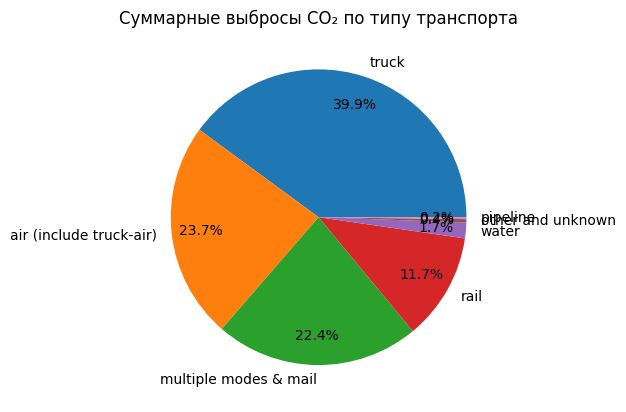

In [11]:
# График типов транспорта
plt.figure()
transport_by_class = df.groupby(["transport_type"])["transport_type"].count().sort_values(ascending=False)
plt.pie(transport_by_class,labels=df['transport_type'].unique(),
        autopct='%1.1f%%',pctdistance=0.8,labeldistance=1.1)
plt.title("Диаграмма распределния количества транспорта в маршрутах")
plt.show()

Вызуализация процентного соотношения используемого транспорта, видим, что около 40% всех маршрутов - это грузовики, 24% - это воздух и воздух+грузовики, и так далее. Это процентное соотношение мы должны сохранить для наших выборок.

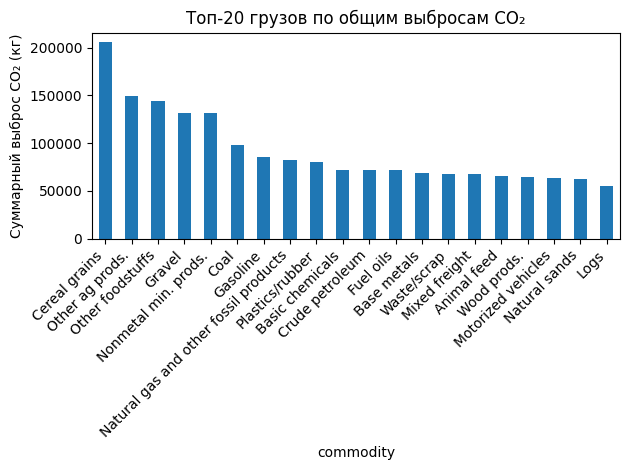

In [12]:
# Парето по типу груза
commodity_agg = df.groupby("commodity")["co2_emissions_kg"].sum().sort_values(ascending=False).head(20)
commodity_agg.plot(kind="bar")
plt.title("Топ-20 грузов по общим выбросам CO₂")
plt.ylabel("Суммарный выброс CO₂ (кг)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

В этом блоке анализируются грузы, которые вносят наибольший вклад в общий углеродный след.


In [19]:
df.groupby(["transport_type","commodity"])["co2_per_ton_km"].sum().sort_values(ascending=False)

transport_type           commodity            
air (include truck-air)  Electronics              158574.570
                         Machinery                137359.740
                         Precision instruments    132958.770
                         Articles-base metal       95899.080
                         Plastics/rubber           93336.360
                                                     ...    
pipeline                 Nonmetal min. prods.          0.028
                         Newsprint/paper               0.028
                         Wood prods.                   0.016
                         Textiles/leather              0.008
                         Waste/scrap                   0.008
Name: co2_per_ton_km, Length: 266, dtype: float64

## Разделение выборки на Train и Test, стратифицируя по виду транспорта



In [20]:
from sklearn.model_selection import train_test_split

#Разбиваем выборку через train_test_split, где train_df составляет 300к семплов, test_df составляет 75к семплов, и стратифицируем по транспорту
train_df, test_df = train_test_split(df,train_size=300000, test_size=75000,stratify=df['transport_type'],random_state=42)
train_df.info(),test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 5308987 to 4171578
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   origin                       300000 non-null  object 
 1   destination                  300000 non-null  object 
 2   distance_km                  300000 non-null  float64
 3   transport_type               300000 non-null  object 
 4   transport_type_code          300000 non-null  int64  
 5   cargo_weight_tons            300000 non-null  float64
 6   commodity                    300000 non-null  object 
 7   commodity_code               300000 non-null  int64  
 8   year                         300000 non-null  int64  
 9   ton_km                       300000 non-null  float64
 10  emission_factor_g_tkm        300000 non-null  int64  
 11  co2_emissions_kg             300000 non-null  float64
 12  co2_per_liter                300000 non-null  float64
 1

(None, None)

In [21]:
#Проверяем пропорции по транспорту

trnnormal = train_df['transport_type'].value_counts(normalize=True)
testnormal = test_df['transport_type'].value_counts(normalize=True)

print(f'Для train_df {trnnormal}, \n\nДля test_df {testnormal}')

Для train_df transport_type
truck                      0.399290
air (include truck-air)    0.237107
multiple modes & mail      0.223527
rail                       0.117147
water                      0.017230
other and unknown          0.003587
pipeline                   0.002113
Name: proportion, dtype: float64, 

Для test_df transport_type
truck                      0.399293
air (include truck-air)    0.237107
multiple modes & mail      0.223520
rail                       0.117147
water                      0.017227
other and unknown          0.003587
pipeline                   0.002120
Name: proportion, dtype: float64


Видим, что пропрции в выборках сохранились (сверяя их с диаграммой). Значит деление выполнилось нормально. Далее сохраним файлы и проверим, сохранились ли соотношения по другим параметрам ввыборках.

In [22]:
train_df.to_csv('logistics_dataset_train.csv')
test_df.to_csv('logistics_dataset_test.csv')

## Анализ train_df

In [46]:
#АНЛИЗ ТРЕЙНА
df = pd.read_csv('/content/logistics_dataset_train.csv')

In [24]:
#Общий углеродный след
total_co2_kg = df["co2_emissions_kg"].sum()

#Средняя интенсивность выбросов на тонно-км
avg_co2_per_tkm = df["co2_per_ton_km"].mean()

#Выбросы по типу транспорта
co2_by_transport = df.groupby("transport_type")["co2_emissions_kg"].sum().sort_values(ascending=False)

#Доля классов экологичности
env_class_share = df["environmental_class"].value_counts(normalize=True) * 100

#Топ-10 "грязных" маршрутов
top10_polluting = df.sort_values("co2_per_ton_km", ascending=False).head(10)[[
    "origin", "destination", "transport_type", "commodity","co2_emissions_kg", "co2_per_ton_km","ton_km"
]]
print(f"Общие выбросы CO₂: {total_co2_kg:,.0f} кг")
print(f"Средняя интенсивность выбросов CO₂ на т·км: {avg_co2_per_tkm:.3f} кг/т·км")
print("Распределение по классам экологичности:\n", env_class_share)


Общие выбросы CO₂: 62,492 кг
Средняя интенсивность выбросов CO₂ на т·км: 0.169 кг/т·км
Распределение по классам экологичности:
 environmental_class
medium    42.010667
low       34.278667
high      23.710667
Name: proportion, dtype: float64


In [32]:
summary_stats = df.groupby(["transport_type","environmental_class"])["co2_per_ton_km"].agg(["median", "mean", "std", "count","sum"]).sort_values(by="median", ascending=False)
summary_stats

,,median,mean,std,count,sum
transport_type,environmental_class,,,,,
air (include truck-air),high,0.570,0.570,0.0,71132,40545.240
other and unknown,medium,0.080,0.080,0.0,1076,86.080
truck,medium,0.071,0.071,0.0,119787,8504.877
water,medium,0.035,0.035,0.0,5169,180.915
rail,low,0.016,0.016,0.0,35144,562.304
multiple modes & mail,low,0.012,0.012,0.0,67058,804.696
pipeline,low,0.004,0.004,0.0,634,2.536


In [25]:
df.groupby([
    "origin", "destination", "transport_type", "commodity"])["co2_emissions_kg"].sum().sort_values(ascending=False)

,,,,co2_emissions_kg
origin,destination,transport_type,commodity,
Rest of TX,Rest of TX,truck,Cereal grains,1.073892e+03
Wyoming,Rest of TX,rail,Coal,1.062569e+03
Iowa,Iowa,truck,Gravel,9.471826e+02
Rest of IL,St. Louis MO-IL (IL Part),truck,Cereal grains,7.981673e+02
Dallas-Fort Worth TX-OK (TX Part),Miami FL,truck,Natural sands,5.830408e+02
...,...,...,...,...
Philadelphia PA-NJ-DE-MD (PA Part),Philadelphia PA-NJ-DE-MD (PA Part),multiple modes & mail,Electronics,1.930800e-08
Baltimore MD,Baltimore MD,multiple modes & mail,Animal feed,1.930800e-08
Tampa FL,Tampa FL,multiple modes & mail,Wood prods.,1.930800e-08


In [26]:
top10_polluting

,origin,destination,transport_type,commodity,co2_emissions_kg,co2_per_ton_km,ton_km
232292,Washington DC-VA-MD-WV (DC Part),Beaumont TX,air (include truck-air),Electronics,0.000286,0.57,0.000502
232293,Rest of AZ,New York NY-NJ-CT-PA (NJ Part),air (include truck-air),Electronics,0.003789,0.57,0.006647
42,Cleveland OH,Dallas-Fort Worth TX-OK (TX Part),air (include truck-air),Electronics,0.001254,0.57,0.002200
299973,Rest of NY,Los Angeles CA,air (include truck-air),Textiles/leather,0.101692,0.57,0.178408
299977,Louisville KY-IN (KY Part),Fresno CA,air (include truck-air),Articles-base metal,0.001362,0.57,0.002389
191981,Miami FL,Rest of MO,air (include truck-air),Precision instruments,0.000008,0.57,0.000014
191990,New York NY-NJ-CT-PA (NJ Part),Wichita KS,air (include truck-air),Nonmetal min. prods.,0.024775,0.57,0.043466
59,New York NY-NJ-CT-PA (NY Part),Rest of AL,air (include truck-air),Electronics,0.002461,0.57,0.004317
62,Rest of KS,Memphis TN-MS-AR (TN Part),air (include truck-air),Nonmetal min. prods.,0.000253,0.57,0.000444
299992,Rest of NC,Los Angeles CA,air (include truck-air),Electronics,0.003275,0.57,0.005746


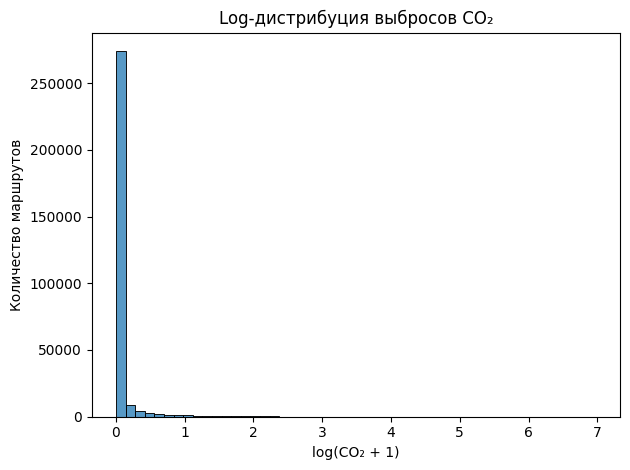

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Гистограмма выбросов CO₂ по маршрутам
plt.figure()
sns.histplot(np.log1p(df["co2_emissions_kg"]), bins=50)
plt.title("Log-дистрибуция выбросов CO₂")
plt.xlabel("log(CO₂ + 1)")
plt.ylabel("Количество маршрутов")
plt.tight_layout()
plt.show()

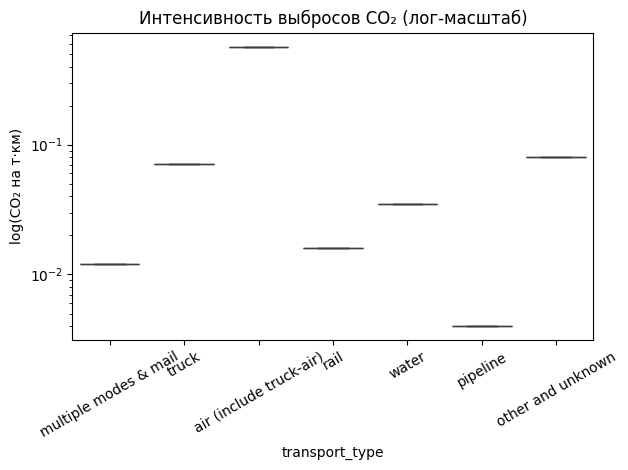

In [28]:
# Boxplot по транспортам

plt.figure()
sns.boxplot(x="transport_type", y="co2_per_ton_km", data=df)
plt.yscale("log")
plt.title("Интенсивность выбросов CO₂ (лог-масштаб)")
plt.ylabel("log(CO₂ на т·км)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

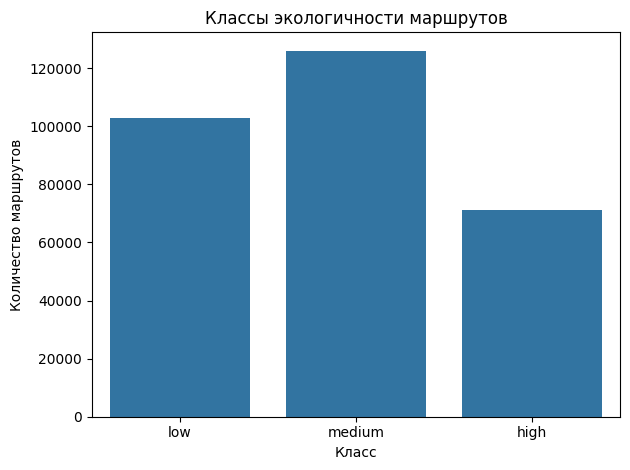

In [29]:
# Распределение классов экологичности
plt.figure()
sns.countplot(x="environmental_class", data=df,
              order=["low", "medium", "high"])
plt.title("Классы экологичности маршрутов")
plt.xlabel("Класс")
plt.ylabel("Количество маршрутов")
plt.tight_layout()
plt.show()

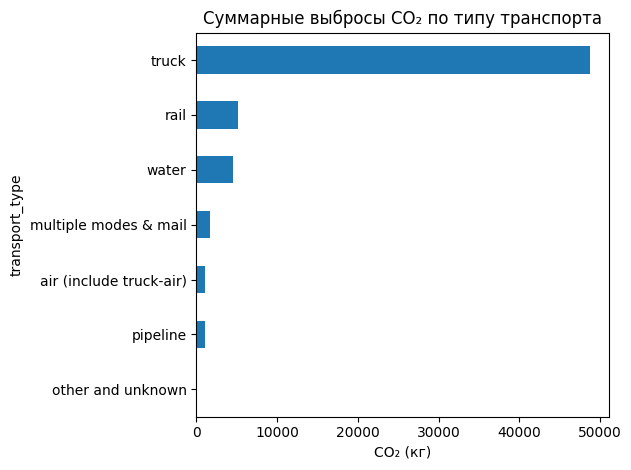

In [30]:
# График выбросов по типу транспорта
plt.figure()
co2_by_type = df.groupby("transport_type")["co2_emissions_kg"].sum().sort_values()
co2_by_type.plot(kind="barh")
plt.title("Суммарные выбросы CO₂ по типу транспорта")
plt.xlabel("CO₂ (кг)")
plt.tight_layout()
plt.show()

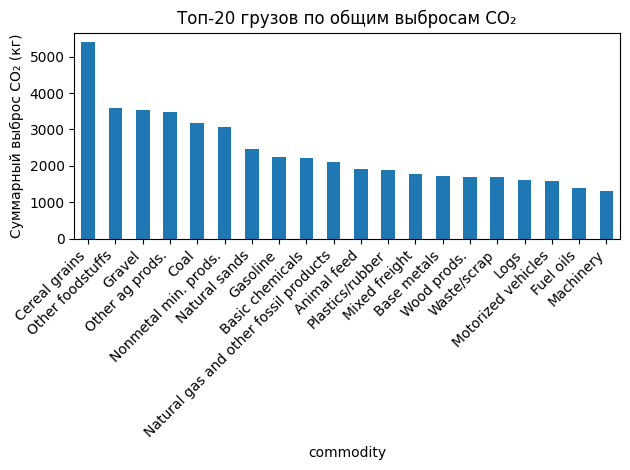

In [31]:
# Парето по типу груза
commodity_agg = df.groupby("commodity")["co2_emissions_kg"].sum().sort_values(ascending=False).head(20)
commodity_agg.plot(kind="bar")
plt.title("Топ-20 грузов по общим выбросам CO₂")
plt.ylabel("Суммарный выброс CO₂ (кг)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [33]:
df.groupby(["transport_type","commodity"])["co2_per_ton_km"].sum().sort_values(ascending=False)

transport_type           commodity            
air (include truck-air)  Electronics              4063.530
                         Machinery                3511.770
                         Precision instruments    3413.730
                         Articles-base metal      2432.760
                         Plastics/rubber          2351.250
                                                    ...   
pipeline                 Nonmetallic minerals        0.016
rail                     Tobacco prods.              0.016
pipeline                 Other foodstuffs            0.008
                         Gravel                      0.004
                         Fertilizers                 0.004
Name: co2_per_ton_km, Length: 253, dtype: float64

Общий вывод: соотношения сохранились, поменялись только абсолютные значения (логично, они уменьшились), маршруты (у нас только 300к маршрутов). В целом, мы видим, что данный датасет мы можем ипользовать для обучения модели, сохраняя при этом смысл и наглядность нашей главной выборки. Посмотрим дополнительно корреляцию признаков в нашей обучаемой выборке.

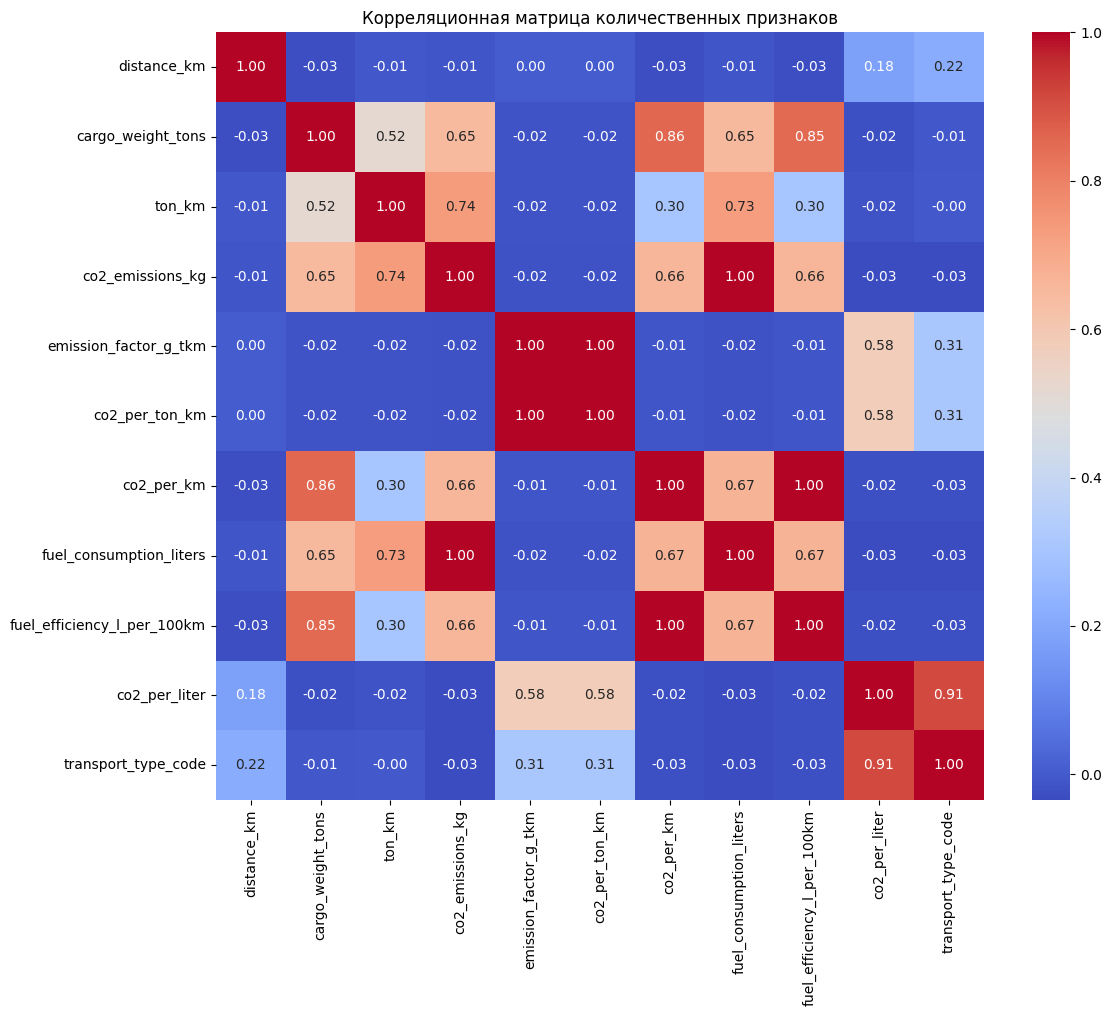

In [47]:
# Выбор количественных переменных, включая закодированный тип транспорта
corr_cols = [
    "distance_km",
    "cargo_weight_tons",
    "ton_km",
    "co2_emissions_kg",
    "emission_factor_g_tkm",
    "co2_per_ton_km",
    "co2_per_km",
    "fuel_consumption_liters",
    "fuel_efficiency_l_per_100km",
    "co2_per_liter",
    "transport_type_code"
]

# Матрица корреляции
corr_matrix = df[corr_cols].corr()

# Визуализация
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Корреляционная матрица количественных признаков")
plt.tight_layout()
plt.show()

## Анализ test_df

In [34]:
#АНЛИЗ ТЕСТА
df = pd.read_csv('/content/logistics_dataset_test.csv')

In [35]:
#Общий углеродный след
total_co2_kg = df["co2_emissions_kg"].sum()

#Средняя интенсивность выбросов на тонно-км
avg_co2_per_tkm = df["co2_per_ton_km"].mean()

#Выбросы по типу транспорта
co2_by_transport = df.groupby("transport_type")["co2_emissions_kg"].sum().sort_values(ascending=False)

#Доля классов экологичности
env_class_share = df["environmental_class"].value_counts(normalize=True) * 100

#Топ-10 "грязных" маршрутов
top10_polluting = df.sort_values("co2_per_ton_km", ascending=False).head(10)[[
    "origin", "destination", "transport_type", "commodity","co2_emissions_kg", "co2_per_ton_km","ton_km"
]]
print(f"Общие выбросы CO₂: {total_co2_kg:,.0f} кг")
print(f"Средняя интенсивность выбросов CO₂ на т·км: {avg_co2_per_tkm:.3f} кг/т·км")
print("Распределение по классам экологичности:\n", env_class_share)


Общие выбросы CO₂: 13,540 кг
Средняя интенсивность выбросов CO₂ на т·км: 0.169 кг/т·км
Распределение по классам экологичности:
 environmental_class
medium    42.010667
low       34.278667
high      23.710667
Name: proportion, dtype: float64


In [36]:
df.groupby([
    "origin", "destination", "transport_type", "commodity"])["co2_emissions_kg"].sum().sort_values(ascending=False)

,,,,co2_emissions_kg
origin,destination,transport_type,commodity,
Rest of MO,Rest of MO,truck,Gravel,3.686061e+02
Rest of WA,Rest of WA,truck,Logs,2.725023e+02
Minneapolis-St. Paul MN-WI (MN Part),New Orleans LA-MS (LA Part),water,Cereal grains,2.713571e+02
Los Angeles CA,Los Angeles CA,truck,Gravel,2.592969e+02
Maine,Maine,truck,Logs,2.267075e+02
...,...,...,...,...
Charleston SC,Charleston SC,multiple modes & mail,Wood prods.,1.930800e-08
Grand Rapids MI,Grand Rapids MI,multiple modes & mail,Electronics,1.930800e-08
Rest of TX,Phoenix AZ,multiple modes & mail,Precision instruments,1.930800e-08


In [37]:
summary_stats = df.groupby(["transport_type","environmental_class"])["co2_per_ton_km"].agg(["median", "mean", "std", "count","sum"]).sort_values(by="median", ascending=False)
summary_stats

,,median,mean,std,count,sum
transport_type,environmental_class,,,,,
air (include truck-air),high,0.570,0.570,0.0,17783,10136.310
other and unknown,medium,0.080,0.080,0.0,269,21.520
truck,medium,0.071,0.071,0.0,29947,2126.237
water,medium,0.035,0.035,0.0,1292,45.220
rail,low,0.016,0.016,0.0,8786,140.576
multiple modes & mail,low,0.012,0.012,0.0,16764,201.168
pipeline,low,0.004,0.004,0.0,159,0.636


In [38]:
top10_polluting

,origin,destination,transport_type,commodity,co2_emissions_kg,co2_per_ton_km,ton_km
47992,Washington DC-VA-MD-WV (DC Part),Rest of WA,air (include truck-air),Chemical prods.,1.631574e-03,0.57,0.002862
47998,Baton Rouge LA,Rest of WA,air (include truck-air),Transport equip.,2.815589e-04,0.57,0.000494
8,Louisville KY-IN (KY Part),Seattle WA,air (include truck-air),Misc. mfg. prods.,1.276462e-02,0.57,0.022394
74998,Rest of WA,Dayton OH,air (include truck-air),Precision instruments,8.345883e-05,0.57,0.000146
47999,Beaumont TX,Washington DC-VA-MD-WV (DC Part),air (include truck-air),Pharmaceuticals,1.925973e-05,0.57,0.000034
48003,Dallas-Fort Worth TX-OK (TX Part),Philadelphia PA-NJ-DE-MD (PA Part),air (include truck-air),Other ag prods.,3.439237e-04,0.57,0.000603
2,Chicago IL-IN-WI (IL Part),Washington DC-VA-MD-WV (VA Part),air (include truck-air),Animal feed,4.335274e-03,0.57,0.007606
48005,Memphis TN-MS-AR (TN Part),North Dakota,air (include truck-air),Articles-base metal,9.171300e-07,0.57,0.000002
27,Louisville KY-IN (KY Part),Houston TX,air (include truck-air),Basic chemicals,1.559121e-05,0.57,0.000027
33,Birmingham AL,Louisville KY-IN (KY Part),air (include truck-air),Articles-base metal,3.017358e-04,0.57,0.000529


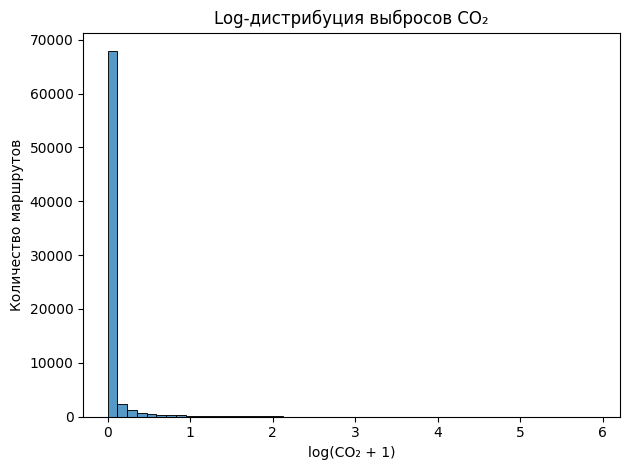

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Гистограмма выбросов CO₂ по маршрутам
plt.figure()
sns.histplot(np.log1p(df["co2_emissions_kg"]), bins=50)
plt.title("Log-дистрибуция выбросов CO₂")
plt.xlabel("log(CO₂ + 1)")
plt.ylabel("Количество маршрутов")
plt.tight_layout()
plt.show()

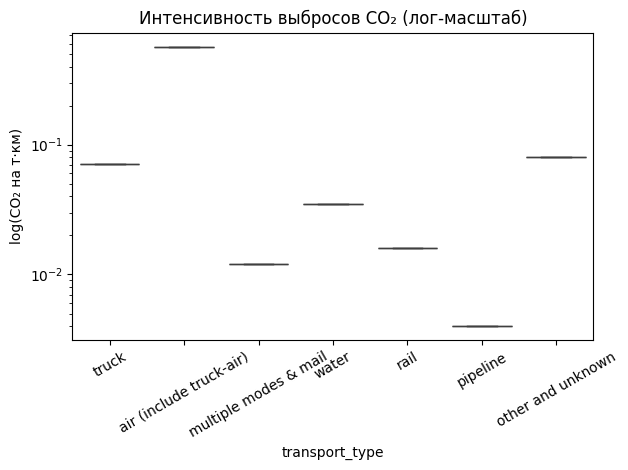

In [40]:
# Boxplot по транспортам

plt.figure()
sns.boxplot(x="transport_type", y="co2_per_ton_km", data=df)
plt.yscale("log")
plt.title("Интенсивность выбросов CO₂ (лог-масштаб)")
plt.ylabel("log(CO₂ на т·км)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

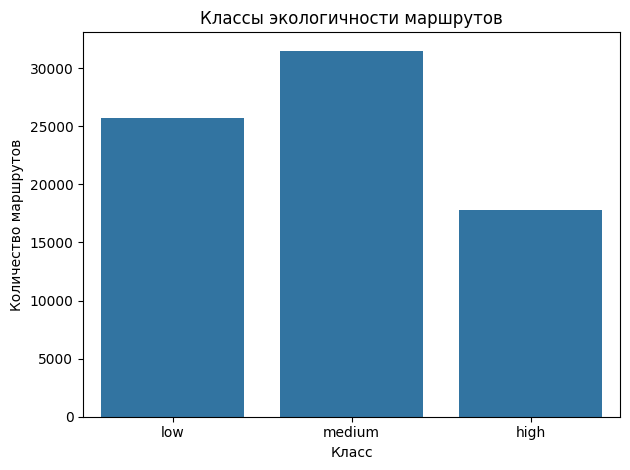

In [41]:
# Распределение классов экологичности
plt.figure()
sns.countplot(x="environmental_class", data=df,
              order=["low", "medium", "high"])
plt.title("Классы экологичности маршрутов")
plt.xlabel("Класс")
plt.ylabel("Количество маршрутов")
plt.tight_layout()
plt.show()

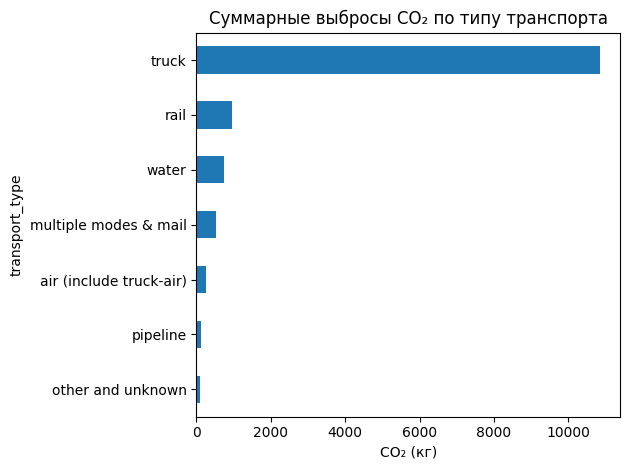

In [42]:
# График выбросов по типу транспорта
plt.figure()
co2_by_type = df.groupby("transport_type")["co2_emissions_kg"].sum().sort_values()
co2_by_type.plot(kind="barh")
plt.title("Суммарные выбросы CO₂ по типу транспорта")
plt.xlabel("CO₂ (кг)")
plt.tight_layout()
plt.show()

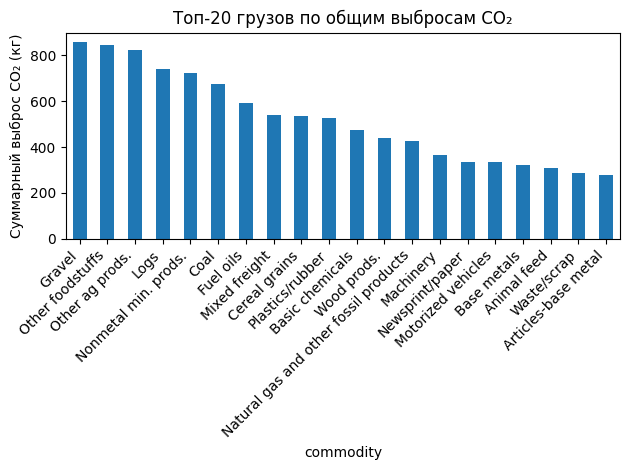

In [44]:
# Парето по типу груза
commodity_agg = df.groupby("commodity")["co2_emissions_kg"].sum().sort_values(ascending=False).head(20)
commodity_agg.plot(kind="bar")
plt.title("Топ-20 грузов по общим выбросам CO₂")
plt.ylabel("Суммарный выброс CO₂ (кг)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Вывод такой же, как и по обучаемой выборке: соотношения сохранились, поменялись абсолютные значения.